![image.png](attachment:image.png)

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base.

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado).

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor as vif


In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
df = pd.read_csv('/content/drive/MyDrive/previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [112]:
# suprindo missings na coluna tempo de emprego com a média

df.loc[df.tempo_emprego.isnull(), 'tempo_emprego'] = df.tempo_emprego.mean()

In [113]:
# criando bases para treino e teste

base_treino = df.loc[df.index.isin(df.index.unique()[-3:]) == False] # separando a base de treino sem os 3 últimos meses

base_teste = df.loc[df.index.isin(df.index.unique()[-3:])] # separando a base de teste com os 3 últimos meses

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [114]:
# criando coluna dos valores log de renda

base_treino['renda_log'] = np.log(base_treino['renda']);
base_teste['renda_log'] = np.log(base_teste['renda']);

<ipython-input-114-acd02ce326e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_treino['renda_log'] = np.log(base_treino['renda']);
<ipython-input-114-acd02ce326e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_teste['renda_log'] = np.log(base_teste['renda']);


In [115]:
# definindo as variáveis explicativas do modelo

variaveis_explicativas = 'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'

# treinando o modelo sobre o variável alvo renda log

res = smf.ols('renda_log ~ '+variaveis_explicativas+'', data=base_treino).fit()

In [116]:
base_treino['residuos'] = res.resid

<ipython-input-116-af3fa4e9d7f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_treino['residuos'] = res.resid


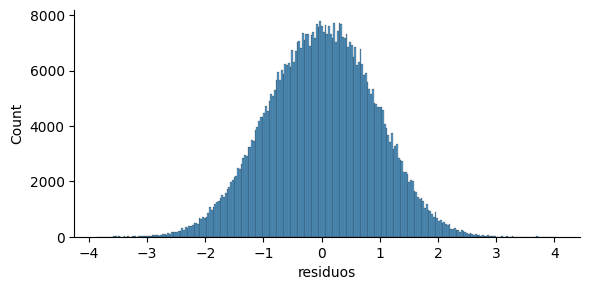

In [117]:
# Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?

sns.displot(base_treino['residuos'], height=3, aspect=2);

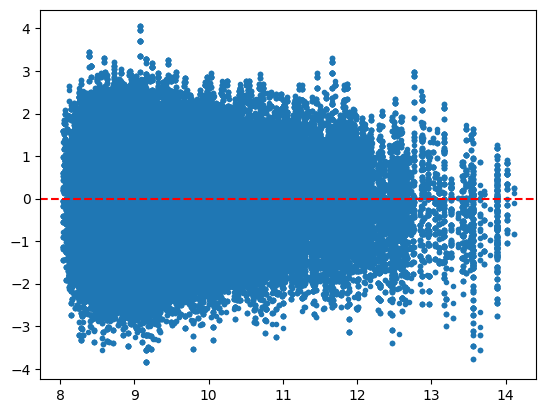

In [118]:
# Faça um gráfico dos resíduos versus os valores preditos

plt.scatter(res.predict(), base_treino['residuos'], marker='.')
plt.axhline(y = 0, color = 'r', linestyle = '--')

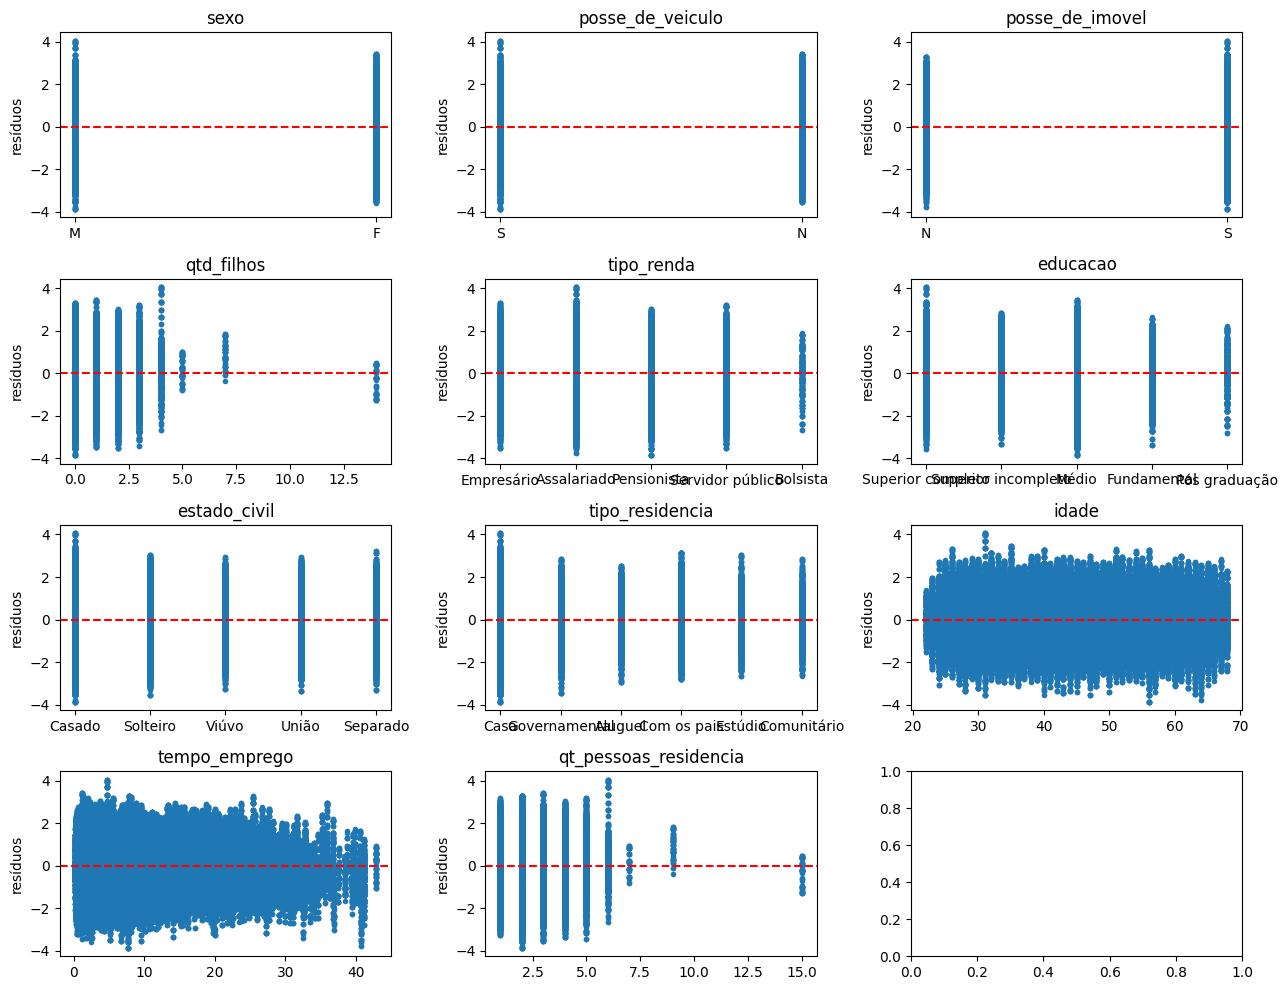

In [119]:
# Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo

lista_variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']

fig, axes = plt.subplots(4, 3, figsize=(13, 10))

i = 0
j = 0

for var in lista_variaveis:

  if j < 3:

    axes[i][j].scatter(base_treino[var], base_treino['residuos'], marker='.')
    axes[i][j].axhline(y = 0, color = 'r', linestyle = '--')
    axes[i][j].set_title(var)
    axes[i][j].set_ylabel('resíduos')

    j = j + 1

  if j == 3:

    i, j = i + 1, 0


plt.tight_layout()
plt.show()

<ipython-input-120-83985c421ffa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_treino['mes'] = [i[5:7] for i in base_treino.index] # criando coluna com meses de referência


Text(0, 0.5, 'média de resíduos')

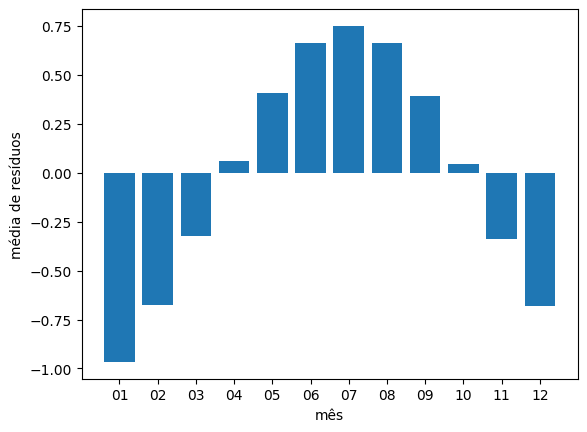

In [120]:
# Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência

base_treino['mes'] = [i[5:7] for i in base_treino.index] # criando coluna com meses de referência

x = base_treino['mes'].unique() # base x com valores dos meses
y = base_treino[['mes', 'residuos']].groupby(by='mes').mean()['residuos'] # base y com os valores da média dos resíduos por mês

plt.bar(x, y)
plt.xlabel('mês')
plt.ylabel('média de resíduos')

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [121]:
base_treino.reset_index(inplace=True)

In [122]:
# treinando o modelo sobre o variável alvo renda log

res_2 = smf.ols('renda_log ~ '+variaveis_explicativas+'', data=base_treino).fit()

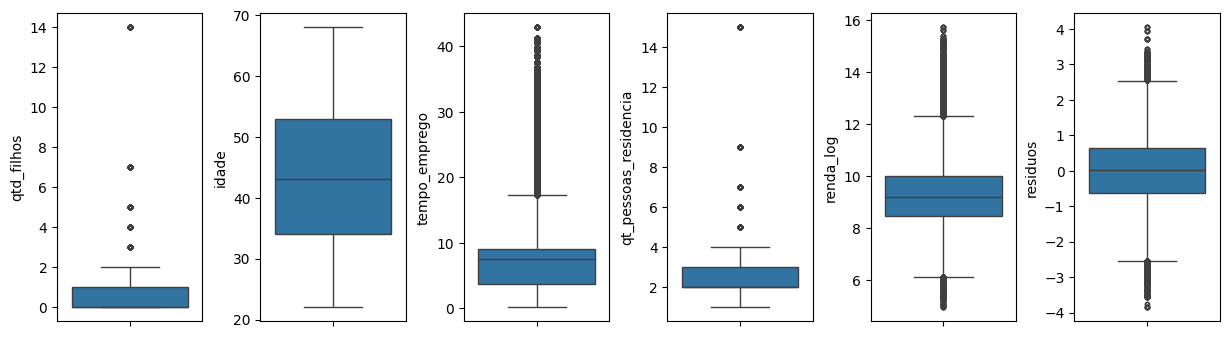

In [123]:
variaveis_numericas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda_log', 'residuos']

fix, ax = plt.subplots(1, 6, figsize=(15,4))
plt.subplots_adjust(wspace=.4, hspace=0)

i = 0

for var in variaveis_numericas:

  sns.boxplot(y = var,data=base_treino, flierprops={"marker": "."}, ax=ax[i])
  ax[i].set_ylabel(var)
  i = i + 1



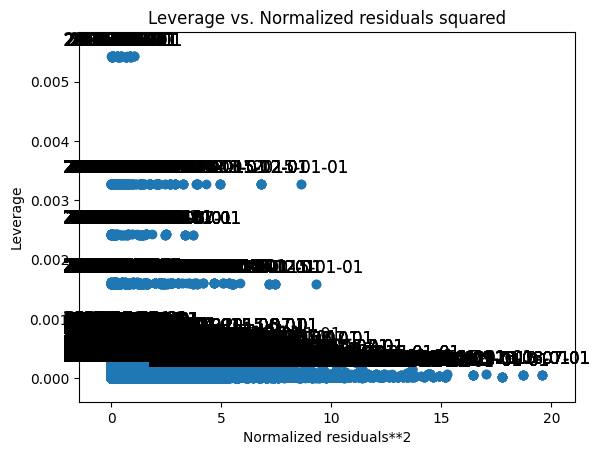

In [124]:

sm.graphics.plot_leverage_resid2(res)
plt.show()


## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

#### *1. Matriz de correlação de Spearman*

In [125]:
def cramers_corrected_stat(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
        return result

In [126]:


def cram(x, y, max_cat=5):
    if (np.dtype(x) in {np.dtype('float64'), np.dtype('int64')}) \
        and (len(np.unique(x)) > max_cat):
            x_ = pd.qcut(x, max_cat)
#             print('#########')
    else: x_ = x
    if (np.dtype(y) in {np.dtype('float64'), np.dtype('int64')}) \
        and (len(np.unique(y)) > max_cat):
            y_ = pd.qcut(y, max_cat)
    else: y_ = y

    return cramers_corrected_stat(x_ ,y_)

<Axes: >

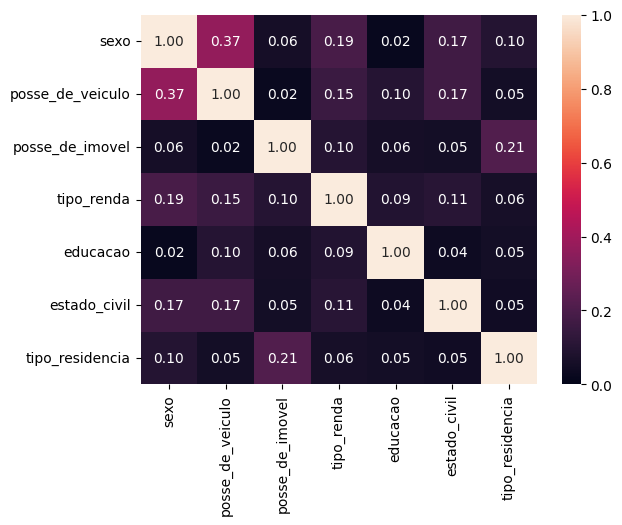

In [127]:
variveis_categoricas = ['sexo',	'posse_de_veiculo',	'posse_de_imovel',	'tipo_renda',	'educacao',	'estado_civil',	'tipo_residencia']

matriz_cramer = pd.DataFrame()

for var1 in variveis_categoricas:
    for var2 in variveis_categoricas:
        matriz_cramer.loc[var1, var2] = cram(base_treino[var1], base_treino[var2], 8)

sns.heatmap(matriz_cramer, vmin=0, vmax=1, annot=True, fmt=".2f")

#### *2. VIF*

In [128]:
# transformando as variaveis categoricas

base_treino_dum = pd.get_dummies(base_treino[variveis_categoricas], drop_first=True)


In [129]:
# calculando VIF para cada variável

vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(base_treino_dum, i) for i in range(base_treino_dum.shape[1])]
vars_vif["Feature"] = base_treino_dum.columns

vars_vif

,VIF Factor,Feature
0,0.000009,sexo_M
1,0.000008,posse_de_veiculo_S
2,0.000008,posse_de_imovel_S
3,0.003290,tipo_renda_Bolsista
4,0.000011,tipo_renda_Empresário
5,0.000014,tipo_renda_Pensionista
6,0.000023,tipo_renda_Servidor público
7,0.000070,educacao_Médio
8,0.001663,educacao_Pós graduação
9,0.000074,educacao_Superior completo


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [130]:
base_treino_2 = base_treino.copy()

In [131]:
# substituindo os outliers pela mediana nas variáveis qtd_filhos, qt_pessoas_residencia, e tempo_emprego

base_treino_2.loc[base_treino_2['qtd_filhos'] >= 4] = base_treino['qtd_filhos'].median()
base_treino_2.loc[base_treino_2['qt_pessoas_residencia'] >= 5] = base_treino['qt_pessoas_residencia'].median()


In [132]:
Q1 = base_treino_2['tempo_emprego'].quantile(0.25)
Q3 = base_treino_2['tempo_emprego'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
base_treino_2.loc[base_treino_2['tempo_emprego'] > limite_superior] = base_treino_2['tempo_emprego'].median()

In [133]:
# treinando novo modelo sobre a base de treino ajustado

res_2 = smf.ols('renda_log ~ '+variaveis_explicativas+'', data=base_treino_2).fit()

In [134]:
# score do primeiro modelo

res.rsquared_adj

0.4377594377090791

In [135]:
# score do segundo modelo

res_2.rsquared_adj

0.5982686555418413